In [1]:
!gdown --id 1eSo7XcOuW1BlLLt4YT5Vo-gK1FgR8xMU

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1eSo7XcOuW1BlLLt4YT5Vo-gK1FgR8xMU
From (redirected): https://drive.google.com/uc?id=1eSo7XcOuW1BlLLt4YT5Vo-gK1FgR8xMU&confirm=t&uuid=87c51741-0f84-48ee-9c2b-7032da5df494
To: /kaggle/working/nature_12K.zip
100%|██████████████████████████████████████| 3.82G/3.82G [01:10<00:00, 54.3MB/s]


In [2]:
!unzip -q nature_12K.zip

In [ ]:
https://drive.google.com/file/d/1eSo7XcOuW1BlLLt4YT5Vo-gK1FgR8xMU/view?usp=sharing

In [4]:
from torch.nn import Module, ReLU, Conv2d, Linear, MaxPool2d, LogSoftmax, NLLLoss, Dropout, BatchNorm2d, LeakyReLU, GELU, SELU, Mish
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch import flatten, float, no_grad
from torch.optim import Adam
import torch
import wandb
import math
import matplotlib.pyplot as plt
import numpy as np

In [19]:
PARAMETERS = {
    'data_augmentation': True,
    'batch_normalization': True,
    'filters': 32, # no. of filters in first layer
    'filter_org': 'double', # 'half', 'double'
    'dropout': 0.2,
    'activation': 'relu',
    'train_data_dir': "/kaggle/working/inaturalist_12K/train",
    'test_data_dir': "/kaggle/working/inaturalist_12K/val",
    'batch_size': 32,
    'learning_rate': 0.001,
    'epochs': 10,
    'dim': 256,
    'conv_kernel_size': 3,
    'dense_neurons': 512
}

In [5]:
CLASSES = {
    0:'Amphibia',
    1:'Animalia',
    2:'Arachnida',
    3:'Aves',
    4:'Fungi',
    5:'Insecta',
    6:'Mammalia',
    7:'Mollusca',
    8:'Plantae',
    9:'Reptilia'
}

In [10]:
def get_data(param, type):
    if(type.lower() == 'train'):
        if param['data_augmentation']:
            transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.3),
                transforms.RandomRotation(degrees=12),
                transforms.Resize((param['dim'],param['dim'])),
                transforms.ToTensor(), 
                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])  
            ])
        else:
            transform = transforms.Compose([
                transforms.Resize((param['dim'],param['dim'])),
                transforms.ToTensor(), 
                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])  
            ])

        tdataset = datasets.ImageFolder(root=param['train_data_dir'], transform=transform)
        total = len(tdataset)
        train_sample = math.ceil(total*(0.8))
        val_sample = total-train_sample
        # print(total, train_sample, val_sample)
        train_dataset, validation_dataset = torch.utils.data.random_split(tdataset, [train_sample, val_sample])
        train_dataloader = DataLoader(train_dataset, batch_size=param['batch_size'], shuffle=True)
        validation_dataloader = DataLoader(validation_dataset, batch_size=param['batch_size'], shuffle=False)
        return train_dataloader, validation_dataloader
    
    else:
        transform = transforms.Compose([
            transforms.Resize((param['dim'],param['dim'])),
            transforms.ToTensor(), 
            transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])  
        ])
        test_dataset = datasets.ImageFolder(root=param['test_data_dir'], transform=transform)
        test_dataloader = DataLoader(test_dataset, batch_size=param['batch_size'])
        return test_dataloader

    

In [11]:
class CNN(Module):
    def __init__(self, param):
        super(CNN, self).__init__()
        self.param=param
        self.data_augmentation = param['data_augmentation']
        self.dropout = param['dropout']
        self.act = self.getActivation(param['activation'])
        self.filters = self.filter_logic(param['filters'], param['filter_org'])
        self.conv_ks = param['conv_kernel_size']
        self.dim = param['dim']
        self.bn = param['batch_normalization']
        self.dense_neurons = param['dense_neurons']


        ####### Layer 1 #######
        curr_dim = self.dim
        self.conv1 = Conv2d(kernel_size=(self.conv_ks,self.conv_ks), in_channels=3, out_channels=self.filters[0])
        curr_dim -= (self.conv_ks-1)
        self.act1 = self.act
        if(self.bn): self.bn1 = BatchNorm2d(self.filters[0])
        self.pool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        curr_dim //= 2
        self.dropout1 = Dropout(p=self.dropout)

        ####### Layer 2 #######
        self.conv2 = Conv2d(kernel_size=(self.conv_ks,self.conv_ks), in_channels=self.filters[0], out_channels=self.filters[1])
        curr_dim -= (self.conv_ks-1)
        self.act2 = self.act
        if(self.bn): self.bn2 = BatchNorm2d(self.filters[1])
        self.pool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        curr_dim //= 2
        self.dropout2 = Dropout(p=self.dropout)

        ####### Layer 3 #######
        self.conv3 = Conv2d(kernel_size=(self.conv_ks,self.conv_ks), in_channels=self.filters[1], out_channels=self.filters[2])
        curr_dim -= (self.conv_ks-1)
        self.act3 = self.act
        if(self.bn): self.bn3 = BatchNorm2d(self.filters[2])
        self.pool3 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        curr_dim //= 2
        self.dropout3 = Dropout(p=self.dropout)

        ####### Layer 4 #######
        self.conv4 = Conv2d(kernel_size=(self.conv_ks,self.conv_ks), in_channels=self.filters[2], out_channels=self.filters[3])
        curr_dim -= (self.conv_ks-1)
        self.act4 = self.act
        if(self.bn): self.bn4 = BatchNorm2d(self.filters[3])
        self.pool4 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        curr_dim //= 2
        self.dropout4 = Dropout(p=self.dropout)


        ####### Layer 5 #######
        self.conv5 = Conv2d(kernel_size=(self.conv_ks,self.conv_ks), in_channels=self.filters[3], out_channels=self.filters[4])
        curr_dim -= (self.conv_ks-1)
        self.act5 = self.act
        if(self.bn): self.bn5 = BatchNorm2d(self.filters[4])
        self.pool5 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        curr_dim //= 2
        self.dropout5 = Dropout(p=self.dropout)

    
        ####### Fully Connected Layer #######
        self.dense_neurons = curr_dim * curr_dim * self.filters[4]
        self.fc1 = Linear(in_features=(curr_dim * curr_dim * self.filters[4]), out_features=self.dense_neurons)  # How to calculate dimension of filters at previous level
        self.act6 = self.act
        self.dropout6 = Dropout(p=0.5)
        

        ####### Output Layer #######
        self.out = Linear(in_features=self.dense_neurons, out_features=10)
        self.act7 = LogSoftmax(dim=1)


    def getActivation(self, act):
        act = act.lower()
        if(act == 'relu'):
            return ReLU()
        elif(act == 'leakyrelu'):
            return LeakyReLU()
        elif(act == 'gelu'):
            return GELU()
        elif(act == 'selu'):
            return SELU()
        elif(act == 'mish'):
            return Mish()
    

    def filter_logic(self, filter, org):
        level = []
        org = org.lower()
        if org == 'same':
            level = [filter for i in range(5)]
        elif org == 'double':
            level = [filter*pow(2,i) for i in range(5)]
        elif org == 'half':
            level = [max(filter//pow(2,i),1) for i in range(5)]
        return level

    

    def forward(self, r):

        r=self.conv1(r)
        r=self.act1(r)
        if(self.bn): r=self.bn1(r)
        r=self.pool1(r)
        r=self.dropout1(r)

        r=self.conv2(r)
        r=self.act2(r)
        if(self.bn): r=self.bn2(r)
        r=self.pool2(r)
        r=self.dropout2(r)

        r=self.conv3(r)
        r=self.act3(r)
        if(self.bn): r=self.bn3(r)
        r=self.pool3(r)
        r=self.dropout3(r)

        r=self.conv4(r)
        r=self.act4(r)
        if(self.bn): r=self.bn4(r)
        r=self.pool4(r)
        r=self.dropout4(r)

        r=self.conv5(r)
        r=self.act5(r)
        if(self.bn): r=self.bn5(r)
        r=self.pool5(r)
        r=self.dropout5(r)

        r=flatten(r,1)
        r=self.fc1(r)
        r=self.act6(r)
        r=self.dropout6(r)
        
        r=self.out(r)
        output=self.act7(r)

        return output
        


In [16]:
# For personal debug use
def train(param):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = CNN(param).to(device)
    optimizer = Adam(model.parameters(), lr=param['learning_rate'])
    loss_function = NLLLoss()
    train_data_loader, validation_data_loader = get_data(param, 'train')
    

    for epo in range(param['epochs']):
        model.train()
        totalTrainLoss = 0
        totalValLoss = 0
        trainCorrect = 0
        valCorrect = 0
        train_counter=0
        validation_counter=0
        for (image, label) in train_data_loader:
            (image, label) = (image.to(device), label.to(device))
            prediction = model(image)
            loss = loss_function(prediction, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            totalTrainLoss += loss
            trainCorrect += (prediction.argmax(1) == label).type(float).sum().item()
            train_counter+=1
            # print(train_counter)
        
        with no_grad():
            model.eval()
            for (image, label) in validation_data_loader:
                (image, label) = (image.to(device), label.to(device))
                pred = model(image)
                totalValLoss += loss_function(pred, label)
                valCorrect += (pred.argmax(1) == label).type(float).sum().item()
                validation_counter+=1

        print(f"Epochs --> {epo}")
        print(f"Train Loss --> {(totalTrainLoss/train_counter).cpu().detach().numpy()}")
        print(f"Train Accuracy --> {trainCorrect/len(train_data_loader.dataset)}")
        print(f"Validation Loss --> {(totalValLoss/validation_counter).cpu().detach().numpy()}")
        print(f"Validation Accuracy --> {valCorrect/len(validation_data_loader.dataset)}")
        print("##########################################################################################")
    
    return model

In [20]:
mdl = train(PARAMETERS)

Epochs --> 0
Train Loss --> 2.7480921745300293
Train Accuracy --> 0.2355
Validation Loss --> 2.8623805046081543
Validation Accuracy --> 0.20060030015007504
##########################################################################################
Epochs --> 1
Train Loss --> 2.0570709705352783
Train Accuracy --> 0.296875
Validation Loss --> 2.531505823135376
Validation Accuracy --> 0.26263131565782893
##########################################################################################
Epochs --> 2
Train Loss --> 1.9406698942184448
Train Accuracy --> 0.332125
Validation Loss --> 2.1835203170776367
Validation Accuracy --> 0.32116058029014505
##########################################################################################
Epochs --> 3
Train Loss --> 1.8274258375167847
Train Accuracy --> 0.3635
Validation Loss --> 2.1511876583099365
Validation Accuracy --> 0.32066033016508255
##########################################################################################
Epochs --

In [22]:
test_data_loader = get_data(PARAMETERS, 'test')
tstCorrect = 0
tstCounter = 0
y = []
y_pred = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
with no_grad():
    mdl.eval()
    for (image, label) in test_data_loader:
        (image, label) = (image.to(device), label.to(device))
        pred = mdl(image)
        y.extend(label.tolist())
        y_pred.extend(pred.argmax(1).tolist())
        # print(pred)
        tstCorrect += (pred.argmax(1) == label).type(float).sum().item()
        tstCounter+=PARAMETERS['batch_size']

print(tstCorrect)
print(tstCounter)
print((tstCorrect/tstCounter)*100)

825.0
2016
40.922619047619044


In [1]:
def plot_confusion_mat(y, y_pred):
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd
    import seaborn as sn
    mp = np.zeros((len(CLASSES),len(CLASSES)))
    for i,j in zip(y, y_pred):
        mp[i][j]+=1

    # df_cm = pd.DataFrame(mp, [i for i in CLASSES.values()], [i for i in CLASSES.values()])
    df_cm = pd.DataFrame(mp, index=CLASSES, columns=CLASSES)
    plt.figure(figsize=(12,12))
    sn.set(font_scale=1) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 9}, cmap='crest', fmt='g') # font size
    plt.xlabel('Prediction')
    plt.ylabel('Actual')


    test_acc= (tstCorrect-70/tstCounter)*100
    wandb.init(project="DA6401_A2")
    wandb.run.name = f'A Q-4 Confusion Matrix'
    wandb.log({"plot":wandb.Image(plt),"Test_accuracy": test_acc})
wandb.finish()

NameError: name 'wandb' is not defined

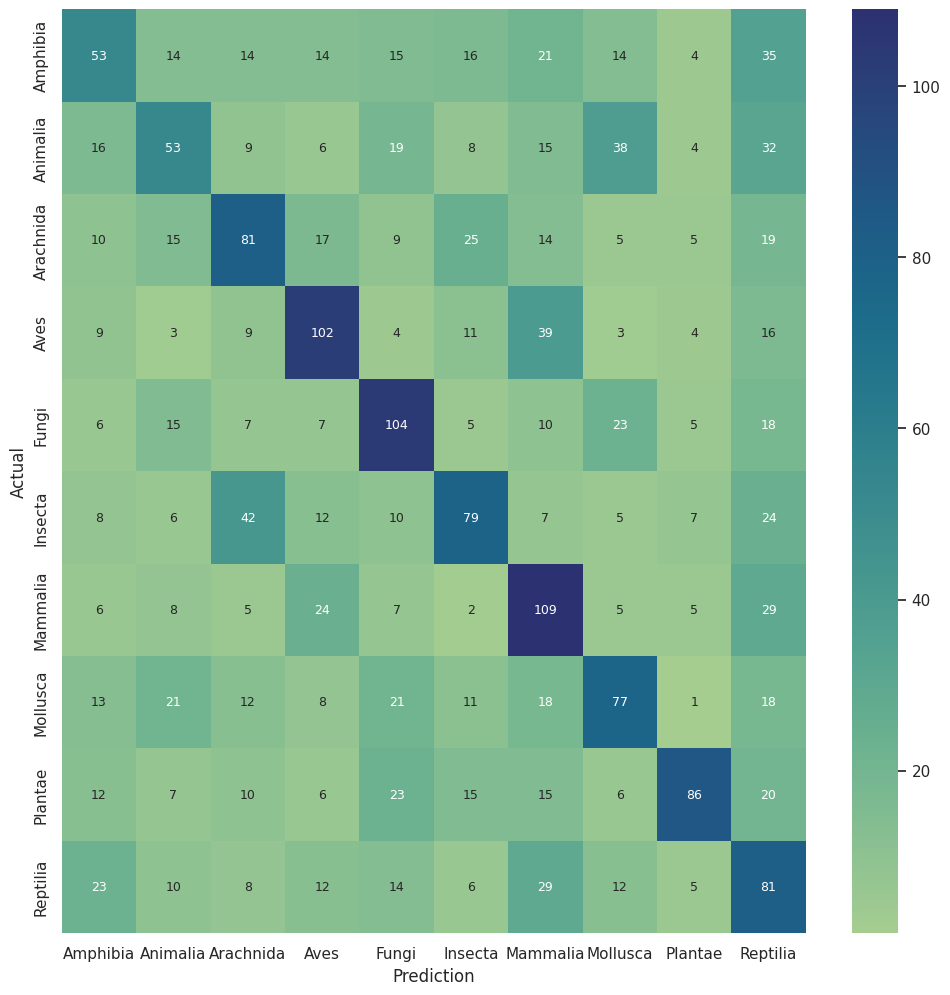

In [37]:
plot_confusion_mat(y,y_pred)

In [8]:
## for wandb sweeps
def train():
    wandb.init()
    param = wandb.config
    wandb.run.name = f'fltr_{param.filters}_fltrOrg_{param.filter_org}_dataAug_{param.data_augmentation}_batchNorm_{param.batch_normalization}_act_{param.activation}_batchSz_{param.batch_size}'

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = CNN(param).to(device)
    optimizer = Adam(model.parameters(), lr=param['learning_rate'])
    loss_function = NLLLoss()
    train_data_loader, validation_data_loader = get_data(param, 'train')
    

    for epo in range(param['epochs']):
        model.train()
        totalTrainLoss = 0
        totalValLoss = 0
        trainCorrect = 0
        valCorrect = 0
        train_counter=0
        validation_counter=0
        for (image, label) in train_data_loader:
            (image, label) = (image.to(device), label.to(device))
            prediction = model(image)
            loss = loss_function(prediction, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            totalTrainLoss += loss
            trainCorrect += (prediction.argmax(1) == label).type(float).sum().item()
            train_counter+=1
          
        
        with no_grad():
            model.eval()
            for (image, label) in validation_data_loader:
                (image, label) = (image.to(device), label.to(device))
                pred = model(image)
                totalValLoss += loss_function(pred, label)
                valCorrect += (pred.argmax(1) == label).type(float).sum().item()
                validation_counter+=1

        tr_ls = (totalTrainLoss/train_counter).cpu().detach().numpy()
        tr_acc = trainCorrect/len(train_data_loader.dataset)
        val_ls = (totalValLoss/validation_counter).cpu().detach().numpy()
        val_acc = valCorrect/len(validation_data_loader.dataset)
        print(f"Epoch --> {epo}")
        print(f"Train Loss --> {tr_ls}")
        print(f"Train Accuracy --> {tr_acc}")
        print(f"Validation Loss --> {val_ls}")
        print(f"Validation Accuracy --> {val_acc}")
        
        lg={
            'epoch': epo+1,
            'tr_accuracy': tr_acc,
            'val_accuracy': val_acc,
            'tr_loss': tr_ls,
            'val_loss': val_ls
        }
        wandb.log(lg)

        # return model

In [9]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

In [54]:
# sweep_config = {
#   "method": "bayes", 
#   "name": "Q2 Sweep",
#   "metric": {"goal": "maximize", "name": "val_accuracy"},
#   "parameters": {
#     "data_augmentation":{"values": [True,False]},  # List of boolean values
#     "batch_normalization":{"values": [True,False]},  # List of boolean values
#     "filters":{"values": [32]},  # List of filter values for first layer
#     "filter_org":{"values": ["same","half","double"]},  # List of filter organization options.. , "half", "double"
#     "dropout":{"values": [0.2,0.3]},  # Dropout rates
#     "activation":{"values": ["relu","leakyrelu","gelu","mish","selu"]},  # Activation functions... , "relu", "leaky_relu"
#     "batch_size":{"values": [32]},
#     "learning_rate":{"values": [0.001,0.0001]},
#     "epochs":{"values": [10]},
#     "dim":{"values": [256]},
#     "conv_kernel_size":{"values": [3,5]},
#     "dense_neurons":{"values": [512]},
#     "train_data_dir":{"values": ["/kaggle/working/inaturalist_12K/train"]},
#     "test_data_dir":{"values": ["/kaggle/working/inaturalist_12K/val"]}
#   }
# }


In [32]:
sweep_config = {
  "method": "bayes", 
  "name": "Q2 Sweep(modified run for find accurate model)",
  "metric": {"goal": "maximize", "name": "val_accuracy"},
  "parameters": {
    "data_augmentation":{"values": [True]},  # List of boolean values
    "batch_normalization":{"values": [True]},  # List of boolean values
    "filters":{"values": [32]},  # List of filter values for first layer
    "filter_org":{"values": ["double"]},  # List of filter organization options.. , "half", "double"
    "dropout":{"values": [0.2]},  # Dropout rates
    "activation":{"values": ["relu"]},  # Activation functions... , "relu", "leaky_relu"
    "batch_size":{"values": [32]},
    "learning_rate":{"values": [0.0001]},
    "epochs":{"values": [15]},
    "dim":{"values": [256]},
    "conv_kernel_size":{"values": [3]},
    "dense_neurons":{"values": [128]},
    "train_data_dir":{"values": ["/kaggle/working/inaturalist_12K/train"]},
    "test_data_dir":{"values": ["/kaggle/working/inaturalist_12K/val"]}
  }
}


In [34]:
wandb.login(key="b8d44a4abbab8753e976a6e5ab717fd669ba99a2")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cs24m030 (cs24m030-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [33]:
# wandb.init()
sweep_id = wandb.sweep(sweep_config, project="DA6401_A2")

Create sweep with ID: ju8yongi
Sweep URL: https://wandb.ai/cs24m030-indian-institute-of-technology-madras/DA6401_A2/sweeps/ju8yongi


In [34]:
wandb.agent(sweep_id, function=train, count=1)
wandb.finish()

wandb: Agent Starting Run: fc9g4ssv with config:
wandb: 	activation: relu
wandb: 	batch_normalization: True
wandb: 	batch_size: 32
wandb: 	conv_kernel_size: 3
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 128
wandb: 	dim: 256
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	filter_org: double
wandb: 	filters: 32
wandb: 	learning_rate: 0.0001
wandb: 	test_data_dir: /kaggle/working/inaturalist_12K/val
wandb: 	train_data_dir: /kaggle/working/inaturalist_12K/train


Epoch --> 0
Train Loss --> 2.7439067363739014
Train Accuracy --> 0.2265
Validation Loss --> 5.075695514678955
Validation Accuracy --> 0.17058529264632316
Epoch --> 1
Train Loss --> 2.0774593353271484
Train Accuracy --> 0.288625
Validation Loss --> 5.123627662658691
Validation Accuracy --> 0.1645822911455728
Epoch --> 2
Train Loss --> 1.9868208169937134
Train Accuracy --> 0.309
Validation Loss --> 5.873669147491455
Validation Accuracy --> 0.17708854427213608
Epoch --> 3
Train Loss --> 1.895666480064392
Train Accuracy --> 0.344125
Validation Loss --> 6.5538763999938965
Validation Accuracy --> 0.16258129064532267
Epoch --> 4
Train Loss --> 1.8395497798919678
Train Accuracy --> 0.366
Validation Loss --> 6.094595909118652
Validation Accuracy --> 0.15807903951975988
Epoch --> 5
Train Loss --> 1.7673914432525635
Train Accuracy --> 0.38875
Validation Loss --> 4.946824073791504
Validation Accuracy --> 0.16808404202101052
Epoch --> 6
Train Loss --> 1.6752547025680542
Train Accuracy --> 0.4235
Va

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
tr_accuracy,▁▂▂▂▃▃▃▄▄▅▆▆▇▇█
tr_loss,█▆▅▅▅▅▄▄▄▃▃▂▂▁▁
val_accuracy,▂▁▂▁▁▁▃▂▃▄▅▇█▆█
val_loss,▅▅▇█▇▅▄▃▄▃▁▁▁▃▂
epoch,15
tr_accuracy,0.782
tr_loss,0.67158
val_accuracy,0.32566
val_loss,3.57911


In [ ]:
import os
import matplotlib.image as mpimg
import random

fig, axes = plt.subplots(10, 3, figsize=(17, 20))


for i in range(10):
    images = []
    folder_name = f"/kaggle/working/inaturalist_12K/val/{CLASSES[i]}/"
    for filename in os.listdir(folder_name):
        images.append(os.path.join(folder_name, filename))
    ind = [random.randint(0, len(images)) for _ in range(3)]
    for j in range(3):
        
        photo = mpimg.imread(images[ind[j]])
        axes[i, j].imshow(photo)
        axes[i, j].set_title(CLASSES[i])
        axes[i, j].axis('off')
        
plt.tight_layout()
plt.show()

wandb.init(project="DA6401_A2")
wandb.run.name = f'AQ4 Sample Images'
wandb.log({"Sample Images ": wandb.Image(fig)})
wandb.finish()


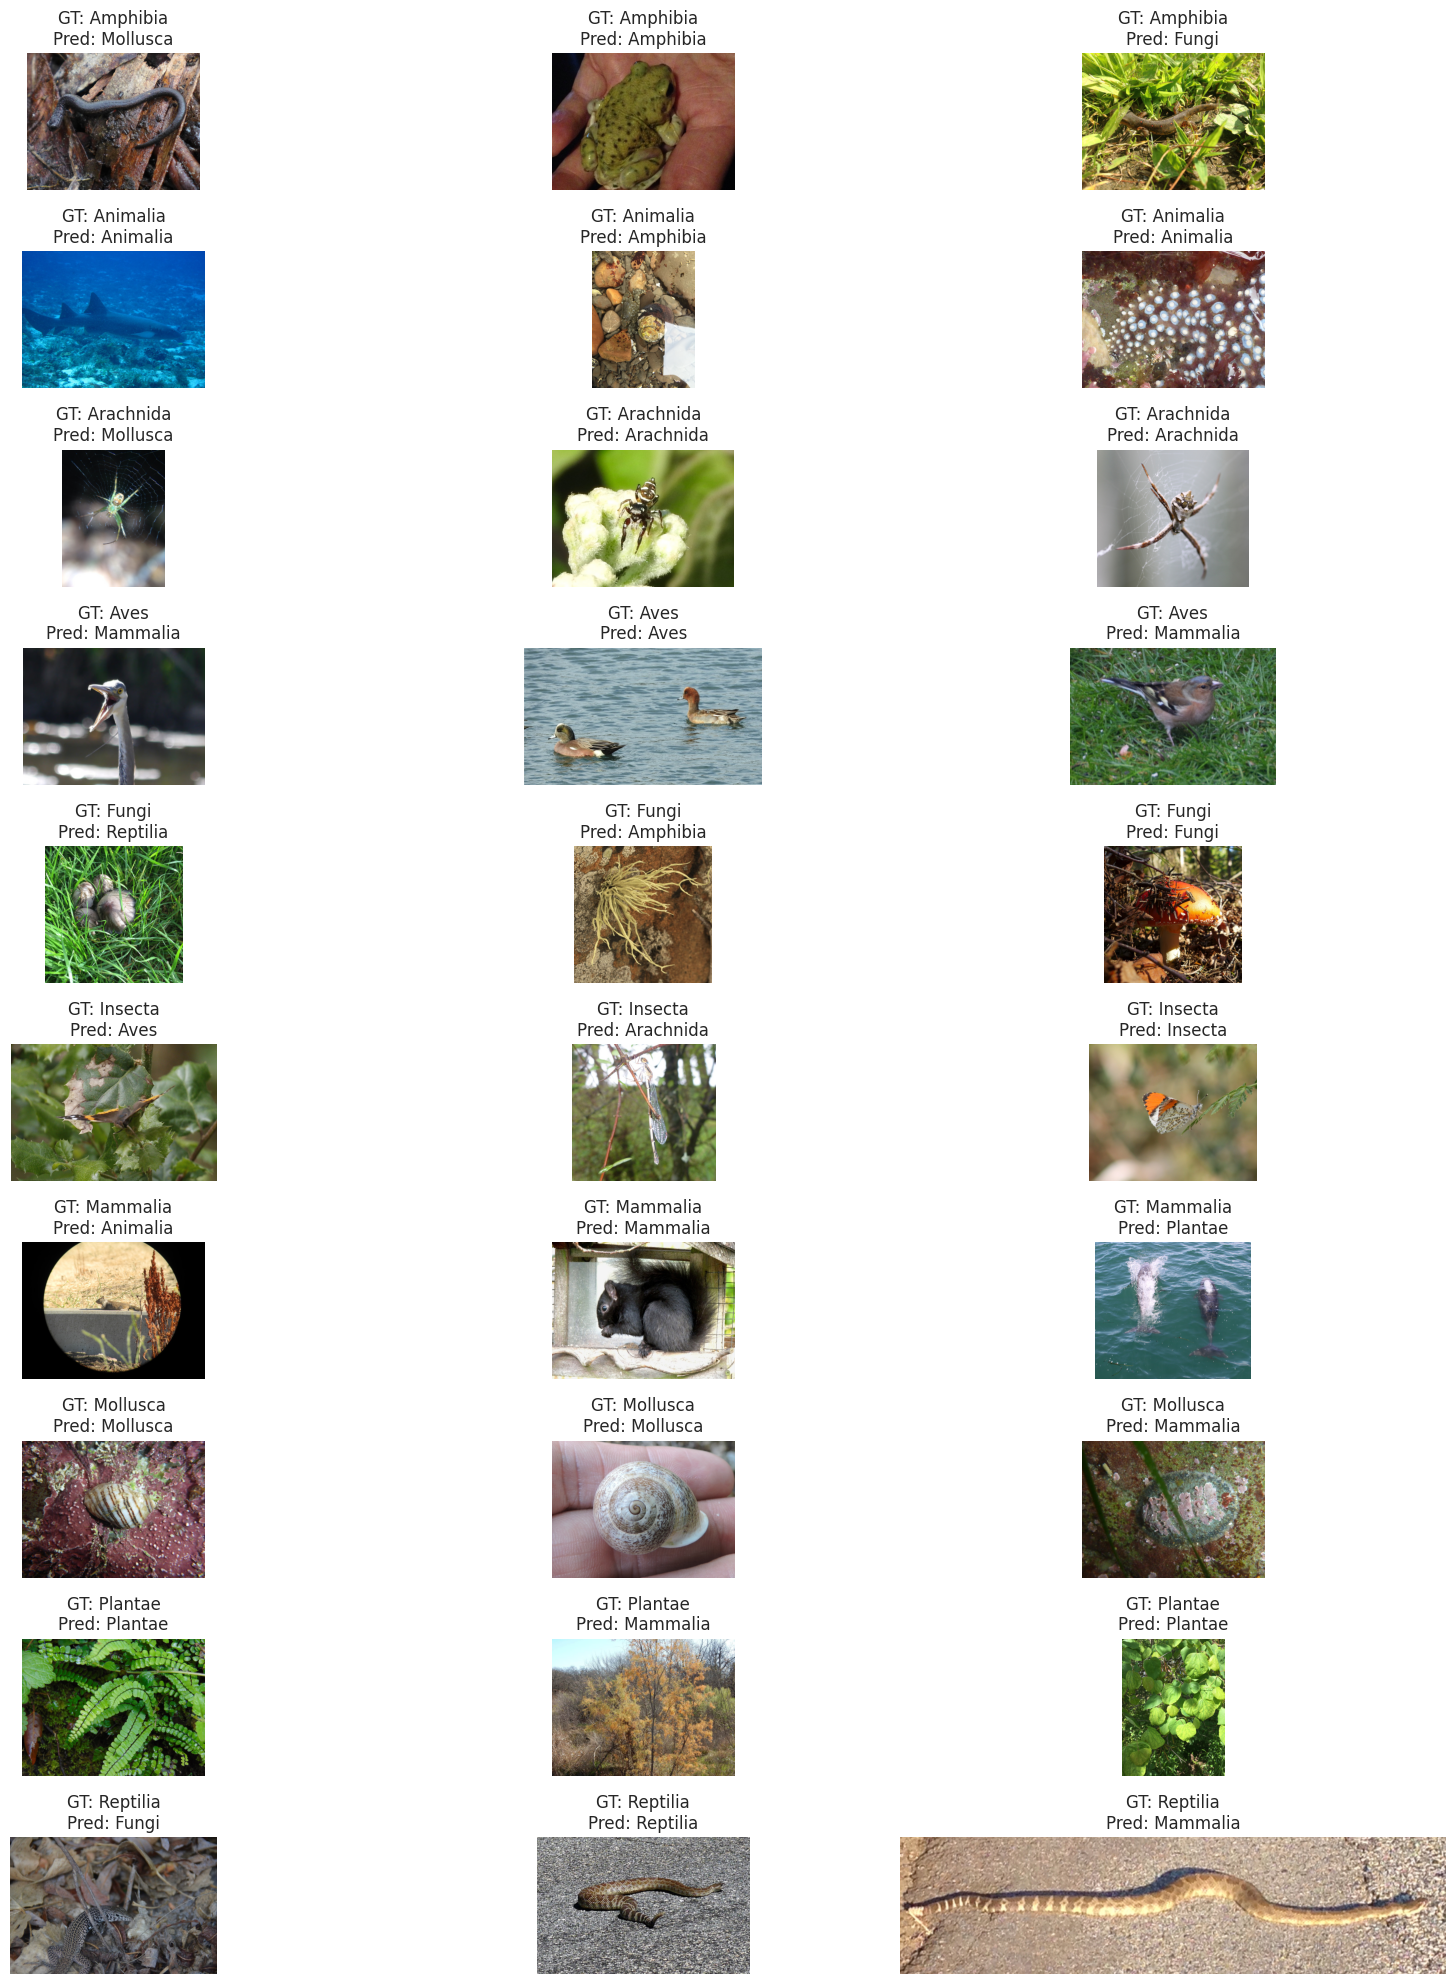

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [35]:
import os
import random
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import wandb
from PIL import Image


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mdl.to(device)
mdl.eval()


CLASSES = os.listdir(PARAMETERS['test_data_dir'])  # Assuming folders per class
CLASSES.sort()  # Ensure consistent class ordering

# --- Transforms (Same as test) ---
transform = transforms.Compose([
    transforms.Resize((PARAMETERS['dim'], PARAMETERS['dim'])),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- Plot Setup ---
fig, axes = plt.subplots(10, 3, figsize=(17, 20))

# --- Prediction Grid ---
for i in range(10):  # For each class
    class_name = CLASSES[i]
    folder = os.path.join(PARAMETERS['test_data_dir'], class_name)
    image_files = os.listdir(folder)
    chosen = random.sample(image_files, 3)  # Random 3 from the class

    for j in range(3):
        img_path = os.path.join(folder, chosen[j])
        
        # Load & transform image
        image = Image.open(img_path).convert('RGB')
        input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dim
        
        # Predict
        with torch.no_grad():
            pred = mdl(input_tensor).argmax(1).item()
            pred_class = CLASSES[pred]
        
        # Plot
        img_np = mpimg.imread(img_path)
        axes[i, j].imshow(img_np)
        axes[i, j].set_title(f"GT: {class_name}\nPred: {pred_class}")
        axes[i, j].axis('off')

# --- Show & Log ---
plt.tight_layout()
plt.show()

# Optional: Log to Weights & Biases
wandb.init(project="DA6401_A2")
wandb.run.name = 'AQ4 GT vs Pred Grid'
wandb.log({"GT vs Pred": wandb.Image(fig)})
wandb.finish()
